# After cloning:
* upload h5 file into Taco-Mask directory (https://github.com/pedropro/TACO/releases/tag/1.0)
* upload original images into Taco-Mask/uploaded_images directory



In [1]:
!git clone https://github.com/abbesmoe/TrashDetection

Cloning into 'TrashDetection'...
remote: Enumerating objects: 3028, done.
remote: Counting objects: 100% (3028/3028), done.
remote: Compressing objects: 100% (2641/2641), done.
remote: Total 3028 (delta 1223), reused 2149 (delta 346), pack-reused 0
Receiving objects: 100% (3028/3028), 98.24 MiB | 29.85 MiB/s, done.
Resolving deltas: 100% (1223/1223), done.


In [2]:
!pip install keras==2.5.0rc0
!pip install 'h5py==2.10.0'

     |████████████████████████████████| 1.2 MB 12.2 MB/s 
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 2.9 MB 12.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires h5py~=3.1.0, but you have h5py 2.10.0 which is incompatible.


In [ ]:
# %tensorflow_version 1.x

In [1]:
%cd TrashDetection/detector/

/content/TrashDetection/detector


In [2]:
%matplotlib inline
import csv
import dataset
import matplotlib.pyplot as plt
import model as modellib
import numpy as np
import os
import skimage.io
import visualize
from config import Config

In [3]:
class_map = {}
with open("taco_config/map_10.csv") as csvfile:
    reader = csv.reader(csvfile)
    class_map = {row[0]:row[1] for row in reader}

TACO_DIR = "../data"
round = None 
subset = "train"
dataset = dataset.Taco()
taco = dataset.load_taco(TACO_DIR, round, subset,
                         class_map=class_map, return_taco=True)

dataset.prepare()

print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

creating index...
index created!
Number of images used: 1500
Class Count: 11
  0. BG                                                
  1. Bottle                                            
  2. Bottle cap                                        
  3. Can                                               
  4. Cigarette                                         
  5. Cup                                               
  6. Lid                                               
  7. Other                                             
  8. Plastic bag + wrapper                             
  9. Pop tab                                           
 10. Straw                                             


In [4]:
class TacoTestConfig(Config):
  NAME = "taco"
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.9
  NUM_CLASSES = 11

  IMAGE_RESIZE_MODE = "square"
  IMAGE_MIN_DIM = 800
  IMAGE_MAX_DIM = 1024

config = TacoTestConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_CLASSLESS_NMS_THRESHOLD 0.9
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
DETECTION_SCORE_RATIO          True
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MASK_SHARE

In [5]:
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_taco.hy',
                          config=config)

model.load_weights('../mask_rcnn_taco_0100.h5', by_name=True,
                   weights_out_path=None)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


In [6]:
class_names = ["BG","Bottle","Bottle cap","Can","Cigarette","Cup",
               "Lid","Other","Plastic bag + wrapper","Pop tab","Straw"]

In [12]:
from os import path
from PIL import Image

%cd ../static/uploads/

imagePath = "../static/uploads/"
imageName = "trash.jpg"
img = Image.open(imageName)

fileName = os.path.splitext(imageName)[0]
fileExtension = os.path.splitext(imageName)[1]

if fileExtension != '.jpg' and fileExtension != '.gif':
  img.convert('RGB').save("{}.jpg".format(fileName))
  imageName = "{}.jpg".format(fileName)

%cd ../../detector/

image = skimage.io.imread(os.path.join(imagePath, imageName))
r = model.detect([image], verbose=0)[0]

/content/TrashDetection/static/uploads
/content/TrashDetection/detector


In [13]:
def min_accuracy(r,a):
  result = {'rois': [], 'masks': [], 'class_ids': [], 'scores': []}
  indecies = []
  for i,ele in enumerate(r['scores']):
    if ele >= a:
      result['rois'].append(r['rois'][i])
      result['class_ids'].append(r['class_ids'][i])
      result['scores'].append(r['scores'][i])
      indecies.append(i)
  
  result['masks'] = r['masks'][:,:,indecies]

  result['rois'] = np.asarray(result['rois'])
  result['masks'] = np.asarray(result['masks'])
  result['class_ids'] = np.asarray(result['class_ids'])
  result['scores'] = np.asarray(result['scores'])
  return result
r = min_accuracy(r,0.8)
print(r['class_ids'])

[]



*** No instances to display *** 



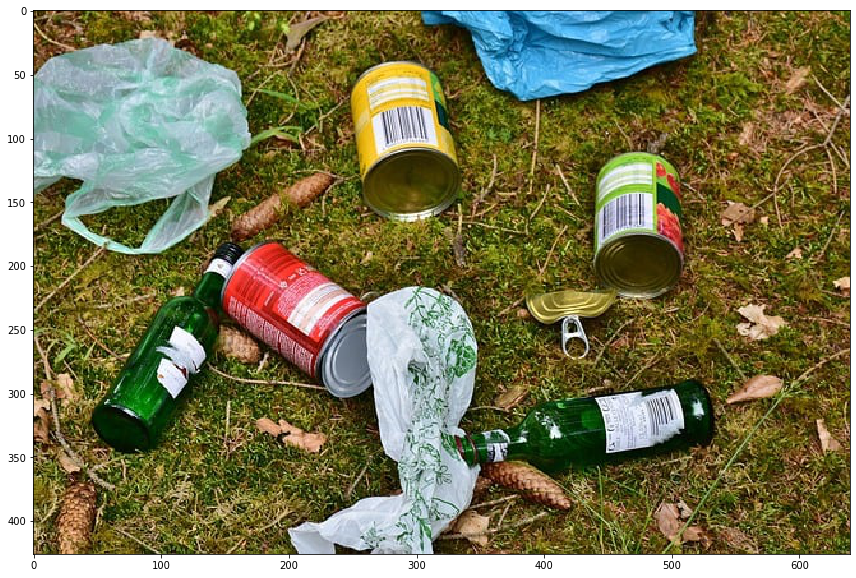

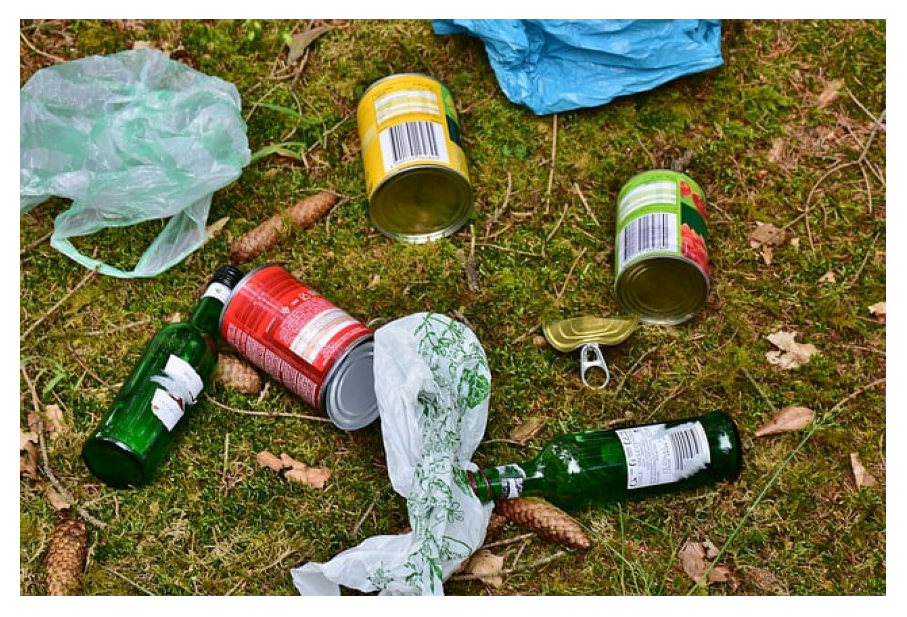

In [11]:
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

visualize.display_instances(image, imageName, r['rois'], r['masks'],
                            r['class_ids'], class_names, r['scores'])

# Blocks for filtering

In [ ]:
#run only once
data = {"Images":[]}

In [ ]:
import json

size = len(r['class_ids'])
i = 0
classNameList = []
while i < size:
  obj_name = class_names[r['class_ids'][i]]
  classNameList.append(obj_name)
  i = i + 1

def write_json(data, filename="../../data.json"):
  with open(filename, "w") as f:
    json.dump(data, f, indent=4)


img_data = {}
img_data["Name"] = "annotated_{}".format(imageName)
img_data["Quantity"] = len(classNameList)
img_data['Classes'] = classNameList

data['Images'].append(img_data)

write_json(data)

In [ ]:
import pandas as pd
import json
pd.set_option("display.max_rows", None, "display.max_columns", None)

with open('../../data.json') as json_data:
    data = json.load(json_data)

df = pd.DataFrame(data['Images'])
print(df)

In [ ]:
def checkQuantity():
  # REPLACE with get method from search page
  userSign = "Greater than"
  print(userSign)
  inp = int(input("Select a quantity: "))
  quantitySet = set()

  if userSign == "":
    return quantitySet

  with open("../../data.json",'r') as json_data:
    data = json.load(json_data)

    for i in range(len(data["Images"])):
      if userSign == 'Greater than':
        if data['Images'][i]['Quantity'] > inp:
          quantitySet.add(data['Images'][i]['Name'])

      elif userSign == 'Less than':
        if data['Images'][i]['Quantity'] < inp:
          quantitySet.add(data['Images'][i]['Name'])

      elif userSign == 'Equal to':
        if data['Images'][i]['Quantity'] == inp:
          quantitySet.add(data['Images'][i]['Name'])

  return quantitySet

a = checkQuantity()
print(a)

In [ ]:
def checkClasses():
  # REPLACE with get method from search page
  selectedOption = "And"
  checkClass = ['Bottle', 'Can']
  classSet = set()

  with open("../../data.json",'r') as json_data:
    data = json.load(json_data)

    if selectedOption == "Or":
        for i in checkClass:
          for j in range(len(data["Images"])):
            if i in data['Images'][j]['Classes']:
              classSet.add(data['Images'][j]['Name'])

    elif selectedOption == "And":
      for i in range(len(data["Images"])):
        if set(checkClass) <= set(data['Images'][i]['Classes']):
          classSet.add(data['Images'][i]['Name'])

    # else:
      # classSet = set()

  return classSet

checkClasses()

In [ ]:
Quantity_set = checkQuantity()
Classes_set = checkClasses()
if len(Quantity_set) != 0 and len(Classes_set) == 0:
  print(Quantity_set)

if len(Quantity_set) == 0 and len(Classes_set) != 0:
  print(Classes_set)

if len(Quantity_set) != 0 and len(Classes_set) != 0:
  print(Quantity_set.intersection(Classes_set))

# Blocks for testing purposes:

In [ ]:
import tensorflow as tf
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_taco.hy',
                          config=config)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

tflite_model.load_weights('../../mask_rcnn_taco_0100.h5', by_name=True,
                   weights_out_path=None)

In [ ]:
class_names = ["BG","Bottle","Bottle cap","Can","Cigarette","Cup",
               "Lid","Other","Plastic bag + wrapper","Pop tab","Straw"]

In [ ]:
from os import path
from PIL import Image

%cd ../../uploaded_images/

imagePath = "../../uploaded_images/"
imageName = "trash.jpg"
img = Image.open(imageName)

fileName = os.path.splitext(imageName)[0]
fileExtension = os.path.splitext(imageName)[1]

if fileExtension != '.jpg' and fileExtension != '.gif':
  img.convert('RGB').save("{}.jpg".format(fileName))
  imageName = "{}.jpg".format(fileName)

%cd ../TACO/detector/
image = skimage.io.imread(os.path.join(imagePath, imageName))
r = model.detect([image], verbose=0)[0]